<a href="https://colab.research.google.com/github/Geobalies2019/Geospatiality/blob/main/NDVI%20time%20series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NDVI time series**

In [17]:
import ee
from datetime import datetime
import folium
import pandas as pd
import geemap

In [49]:
# Initialize Earth Engine

#ee.Authenticate()
#ee.Initialize()



**Create a collection of clean Sentinel-2 images**

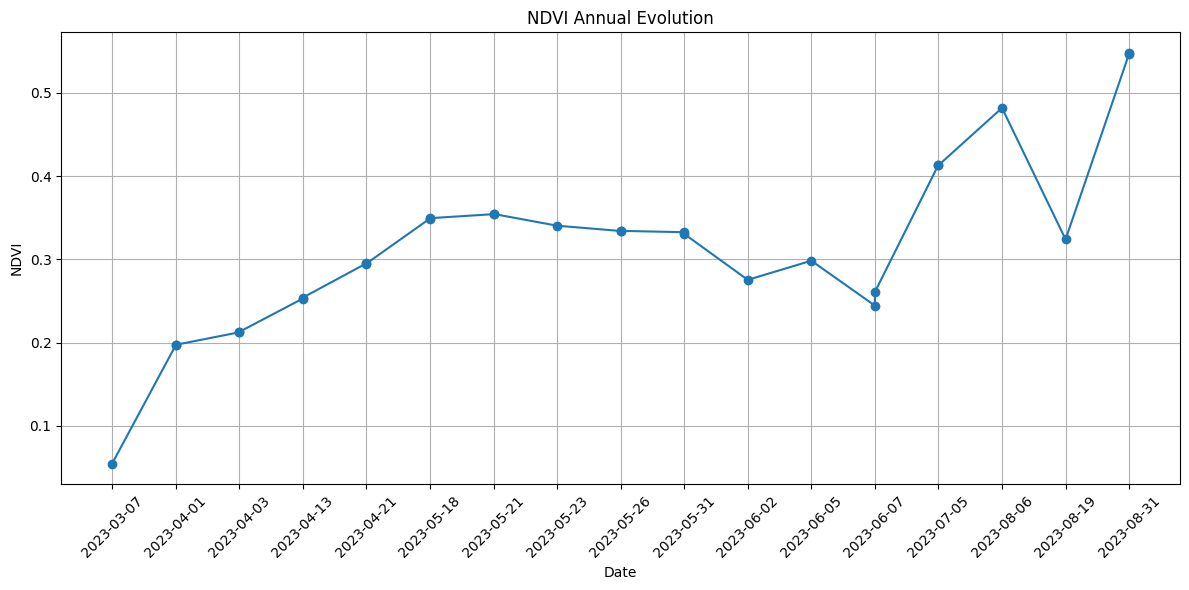

In [48]:
# Create a polygon representing your plot
geometry = ee.Geometry.Polygon(
    [[[-79.39000286081905, 41.52846690118791],
      [-79.38354410151119, 41.52544684004797],
      [-79.3822137258398, 41.52660347586408],
      [-79.3854538343298, 41.52890062179616],
      [-79.38890851954098, 41.529318275930045],
      [-79.39000286081905, 41.52846690118791]]])

# Apply a negative buffer to the plot geometry
geometry_buff = geometry.buffer(-20)

# Load the Sentinel-2 image collection
S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
      .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20)
      .filterDate('2023-01-01', '2023-09-01')
      .filterBounds(geometry_buff))

# Function to filter for vegetation and soil pixels
def keepFieldPixel(image):
    scl = image.select('SCL')
    veg = scl.eq(4)  # 4 = Vegetation
    soil = scl.eq(5)  # 5 = Bare soils
    mask = (veg.neq(1)).Or(soil.neq(1))
    return image.updateMask(mask)

# Apply the custom filter to the Sentinel-2 collection
S2_filtered = S2.map(keepFieldPixel)

# Function to mask clouds in Sentinel-2 imagery
def maskS2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask)

# Apply the cloud masking function to the filtered collection
S2_filtered = S2_filtered.map(maskS2clouds)

# Function to compute NDVI and add it as a new band
def addNDVI(image):
    return image.addBands(image.normalizedDifference(['B8', 'B4']))

# Add the NDVI band to the image collection
S2_with_ndvi = S2_filtered.map(addNDVI)

# Create a list of NDVI images
ndvi_images = S2_with_ndvi.toList(S2_with_ndvi.size())

# Create lists to store dates and NDVI values
dates = []
ndvi_values = []

# Iterate through the image collection
for i in range(0, S2_with_ndvi.size().getInfo()):
    image = ee.Image(ndvi_images.get(i))
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    ndvi = image.select('nd').reduceRegion(reducer=ee.Reducer.mean(),
                                           geometry=geometry_buff,
                                           scale=10).get('nd').getInfo()
    dates.append(date)
    ndvi_values.append(ndvi)

# Create a chart using the matplotlib library
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates, ndvi_values, marker='o', linestyle='-')
plt.title('NDVI Annual Evolution')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the chart
plt.show()


In [45]:

# Apply a negative buffer to the plot geometry
geometry_buff = geometry.buffer(-20)
# Load the Sentinel-2 image collection (assuming 'S2' has already been defined)
# Load the Sentinel-2 image collection
S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
      .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20)
      .filterDate('2023-01-01', '2023-09-01')
      .filterBounds(geometry_buff))

# Function to keep only vegetation and soil pixels (assuming 'keepFieldPixel' function is defined)
S2 = S2.map(keepFieldPixel)

# Function to mask clouds in Sentinel-2 imagery (assuming 'maskS2clouds' function is defined)
S2 = S2.map(maskS2clouds)

# Function to compute NDVI and add it as a new band (assuming 'addNDVI' function is defined)
S2 = S2.map(addNDVI)

# Extract NDVI band from S2 collection
NDVI = S2.select(['nd'])

# Extract median NDVI value for each pixel
NDVImed = NDVI.median()

# Define a color palette for NDVI visualization
palette = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#a6d96a']

# Display NDVI results on the map
Map = geemap.Map()
Map.centerObject(geometry_buff, 10)
Map.addLayer(NDVImed.clip(geometry_buff), {'min': 0.2, 'max': 0.4, 'palette': palette}, 'NDVI')
Map

Map(center=[41.527614468447446, -79.38587981711616], controls=(WidgetControl(options=['position', 'transparent…